In [ ]:
reset -sf

In [427]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Conv1D, \
                        MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D,Input,Concatenate,Merge, \
                        concatenate, Reshape, UpSampling1D,add, LeakyReLU
from keras.regularizers import l2
from keras.models import model_from_json

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 

import matplotlib.pyplot as plt

In [ ]:
PATH = Path("../../data/")

In [67]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [283]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [319]:
trainY_n = dfY_Train[:,ini:ini+dim]
valY_n = dfY_Val[:,ini:ini+dim]
testY_n = dfY_Test[:,ini:ini+dim]

In [320]:
trainX_0_n = dfX_Train [:,ini:ini+dim]
trainX_1_n = dfX_Train [:,ini+ecg:ini+ecg+dim]

valX_0_n =dfX_Val [:,ini:ini+dim]
valX_1_n = dfX_Val[:,ecg+ini:ini+ecg+dim]

testX_0_n = dfX_Test[:,ini:ini+dim]
testX_1_n = dfX_Test[:,ecg+ini:ini+ecg+dim]

trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

4.5 -3.498 0.8156937694160916
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [321]:
# Standardize

In [322]:
scaler_ppg = StandardScaler().fit(trainX_n[:,:,0])
scaler_ecg = StandardScaler().fit(trainX_n[:,:,1])
print(scaler_ppg.mean_.shape)
print(scaler_ecg.mean_.shape)

(250,)
(250,)


In [323]:
trainX_n = np.stack((scaler_ppg.transform(trainX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(trainX_n[:,:,1]).reshape(-1,dim)), axis=2)
valX_n = np.stack((scaler_ppg.transform(valX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(valX_n[:,:,1]).reshape(-1,dim)), axis=2)
testX_n = np.stack((scaler_ppg.transform(testX_n[:,:,0]).reshape(-1,dim), scaler_ecg.transform(testX_n[:,:,1]).reshape(-1,dim)), axis=2)

print(trainX_n.max(), trainX_n.min(), trainX_n.std())
print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

12.232114683629453 -11.461019164899536 1.0000000000000004
(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [289]:
#Data Aug

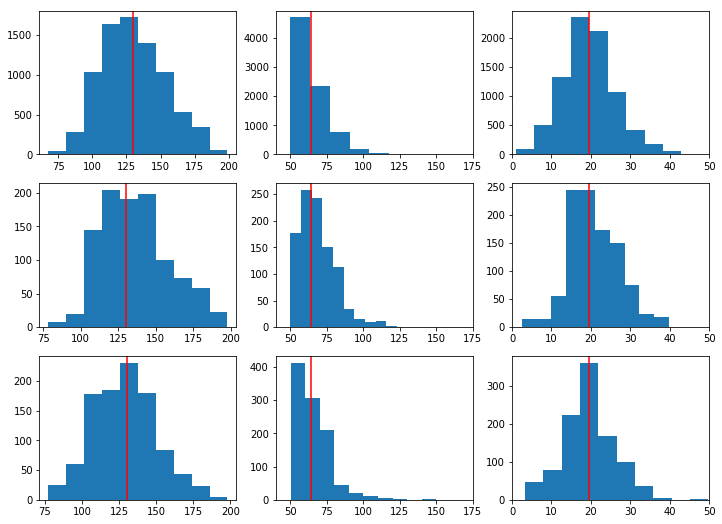

In [324]:
plt.figure(figsize=(12,9))

ax = plt.subplot(3,3,1)
ax.axvline(np.mean(trainY_n.max(axis=1)),c="r")
ax.hist(trainY_n.max(axis=1))

ax = plt.subplot(3,3,2)
ax.hist(trainY_n.min(axis=1))
ax.axvline(np.mean(trainY_n.min(axis=1)),c="r")
ax.set_xlim(40,175)

ax = plt.subplot(3,3,3)
ax.hist(trainY_n.std(axis=1))
ax.axvline(np.mean(trainY_n.std(axis=1)),c="r")
ax.set_xlim(0,50)

ax = plt.subplot(3,3,4)
ax.hist(valY_n.max(axis=1))
ax.axvline(np.mean(trainY_n.max(axis=1)),c="r")

ax = plt.subplot(3,3,5)
ax.hist(valY_n.min(axis=1))
ax.axvline(np.mean(trainY_n.min(axis=1)),c="r")
ax.set_xlim(40,175)

ax = plt.subplot(3,3,6)
ax.hist(valY_n.std(axis=1))
ax.axvline(np.mean(trainY_n.std(axis=1)),c="r")
ax.set_xlim(0,50)

ax = plt.subplot(3,3,7)
ax.hist(testY_n.max(axis=1))
ax.axvline(np.mean(trainY_n.max(axis=1)),c="r")

ax = plt.subplot(3,3,8)
ax.hist(testY_n.min(axis=1))
ax.axvline(np.mean(trainY_n.min(axis=1)),c="r")
ax.set_xlim(40,175)

ax = plt.subplot(3,3,9)
ax.hist(testY_n.std(axis=1))
ax.axvline(np.mean(trainY_n.std(axis=1)),c="r")
ax.set_xlim(0,50)

plt.show()

In [169]:
"""
mx = trainY_n.max(axis=1)

trainX_n = np.vstack((trainX_n,
                      trainX_n[mx<90],
                      trainX_n[mx<90],
                      trainX_n[mx<90],
                      trainX_n[np.logical_or(mx<90, mx>160),:], 
                      trainX_n[np.logical_or(mx<90, mx>160),:]))
trainY_n = np.vstack((trainY_n,
                      trainY_n[mx<90],
                      trainY_n[mx<90],
                      trainY_n[mx<90],
                      trainY_n[np.logical_or(mx<90, mx>160),:], 
                      trainY_n[np.logical_or(mx<90, mx>160),:]))

print(trainX_n.shape, trainY_n.shape)
"""

(10979, 250, 2) (10979, 250)


In [326]:
mn = trainY_n.min(axis=1)

trainX_n = np.vstack((trainX_n,
                      trainX_n[np.logical_and(mn>70, mn<90),:],
                      trainX_n[mn>100,:]))
trainY_n = np.vstack((trainY_n,
                      trainY_n[np.logical_and(mn>70, mn<90),:],
                      trainY_n[mn>100,:]))

print(trainX_n.shape, trainY_n.shape)

(9946, 250, 2) (9946, 250)


In [ ]:
#Build network

In [442]:
d = 0.3
wd = 1e-4
residual = True

In [443]:
input_tensor = Input(shape=(dim,2))
x = Conv1D(128, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(input_tensor)
x = Conv1D(128, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x)
x = Conv1D(128, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x)
x = BatchNormalization()(x)
x = Dropout(d)(x)
x_0 = LeakyReLU()(x)

x = Conv1D(64, 9, padding='same', strides=2, kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x_0)
x = Conv1D(64, 9, padding='same', kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x)
x = Conv1D(64, 9, padding='same', kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x)
x = BatchNormalization()(x)
x = Dropout(d)(x)
x_1 = LeakyReLU()(x)

x = Conv1D(32, 9, padding='same',strides=5, kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x_1)
x = Conv1D(32, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x)
x = Conv1D(32, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(x)
x = BatchNormalization()(x)
x = Dropout(d)(x)
x_2 = LeakyReLU()(x)

encoded = MaxPooling1D(5, padding='same')(x_2)

# at this point the representation is (32, 8) i.e. 128-dimensional

y = Conv1D(32, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(encoded)
y = Conv1D(32, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y)
y = Conv1D(32, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y)
y = BatchNormalization()(y)
y = Dropout(d)(y)
y = LeakyReLU()(y)

y_0 = UpSampling1D(5)(y)
if residual: y_0 = add([x_2,y_0])

y = Conv1D(64, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y_0)
y = Conv1D(64, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y)
y = Conv1D(64, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y)
y = BatchNormalization()(y)
y = Dropout(d)(y)
y = LeakyReLU()(y)

y_1 = UpSampling1D(5)(y)
if residual: y_1 = add([x_1,y_1])

y = Conv1D(128, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y_1)
y = Conv1D(128, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y)
y = Conv1D(128, 9, padding='same',kernel_regularizer=l2(wd), bias_regularizer=l2(wd))(y)
y = BatchNormalization()(y)
y = Dropout(d)(y)
y = LeakyReLU()(y)

y_2 = UpSampling1D(2)(y)
if residual: y_2 = add([x_0,y_2])

decoded = Conv1D(1,1)(y_2)

autoencoder = Model(input_tensor, decoded)
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          (None, 250, 2)       0                                            
__________________________________________________________________________________________________
conv1d_666 (Conv1D)             (None, 250, 128)     2432        input_101[0][0]                  
__________________________________________________________________________________________________
conv1d_667 (Conv1D)             (None, 250, 128)     147584      conv1d_666[0][0]                 
__________________________________________________________________________________________________
conv1d_668 (Conv1D)             (None, 250, 128)     147584      conv1d_667[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [444]:
# fit model
autoencoder.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mae')
history_prev = history
history = autoencoder.fit(trainX_n, np.expand_dims(trainY_n, axis=2), 
                          validation_data=(valX_n, np.expand_dims(valY_n, axis=2)), batch_size=64, epochs=10, verbose=1)

Train on 9946 samples, validate on 1016 samples
Epoch 1/10
9946/9946 [==============================] - 52s 5ms/step - loss: 80.5124 - val_loss: 69.2636
Epoch 2/10
9946/9946 [==============================] - 14s 1ms/step - loss: 52.4355 - val_loss: 52.4970
Epoch 3/10
9946/9946 [==============================] - 14s 1ms/step - loss: 20.1369 - val_loss: 23.0633
Epoch 4/10
9946/9946 [==============================] - 14s 1ms/step - loss: 15.3777 - val_loss: 18.1431
Epoch 5/10
9946/9946 [==============================] - 14s 1ms/step - loss: 14.6512 - val_loss: 14.6302
Epoch 6/10
9946/9946 [==============================] - 14s 1ms/step - loss: 14.3447 - val_loss: 15.5649
Epoch 7/10
9946/9946 [==============================] - 14s 1ms/step - loss: 14.0232 - val_loss: 14.3879
Epoch 8/10
9946/9946 [==============================] - 14s 1ms/step - loss: 13.8583 - val_loss: 15.5572
Epoch 9/10
9946/9946 [==============================] - 14s 1ms/step - loss: 13.7177 - val_loss: 13.7501
Epoch 1

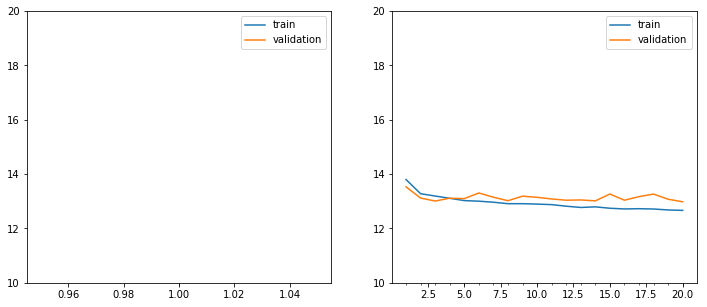

In [415]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.set_ylim(10,20)
    ax.legend()

plt.show()

In [ ]:
# Save the weights and architecture

In [423]:
autoencoder.save_weights('ae.h5')
with open('ae.json', 'w') as f:
    f.write(autoencoder.to_json())

In [ ]:
#ensemble

In [ ]:
lr_0 = 1e-4
ep_0 = 1
lr_1 = 1e-4
ep_1 = 10
for i in range(5):

    print("Increasing lr:", i)
    autoencoder.compile(optimizer=optimizers.Adam(lr=lr_0), loss='mae')
    autoencoder.fit(trainX_n, np.expand_dims(trainY_n, axis=2), 
                    validation_data=(valX_n, np.expand_dims(valY_n, axis=2)), batch_size=64, epochs=ep_0, verbose=1)

    print("Decreasing lr:", i)
    autoencoder.compile(optimizer=optimizers.Adam(lr=lr_1), loss='mae')
    autoencoder.fit(trainX_n, np.expand_dims(trainY_n, axis=2), 
                    validation_data=(valX_n, np.expand_dims(valY_n, axis=2)), batch_size=64, epochs=ep_1, verbose=1)


    print("Saving model:", i)
    autoencoder.save_weights("ae_" + str(i) + ".h5")
    with open("ae_" + str(i) + ".json", 'w') as f:
        f.write(autoencoder.to_json())

Increasing lr: 0
Train on 9946 samples, validate on 1016 samples
Epoch 1/1
9946/9946 [==============================] - 52s 5ms/step - loss: 13.2041 - val_loss: 13.6120
Decreasing lr: 0
Train on 9946 samples, validate on 1016 samples
Epoch 1/10
9946/9946 [==============================] - 52s 5ms/step - loss: 13.1695 - val_loss: 13.3875
Epoch 2/10
9946/9946 [==============================] - 14s 1ms/step - loss: 13.0928 - val_loss: 13.0107
Epoch 3/10
9946/9946 [==============================] - 14s 1ms/step - loss: 13.0777 - val_loss: 13.2595
Epoch 4/10
9946/9946 [==============================] - 14s 1ms/step - loss: 13.0584 - val_loss: 13.0105
Epoch 5/10
9946/9946 [==============================] - 14s 1ms/step - loss: 13.0402 - val_loss: 13.2819
Epoch 6/10
9946/9946 [==============================] - 14s 1ms/step - loss: 12.9757 - val_loss: 13.1417
Epoch 7/10
9946/9946 [==============================] - 14s 1ms/step - loss: 12.9577 - val_loss: 13.4192
Epoch 8/10
9946/9946 [=========

In [428]:
autoencoders = []
for i in range(5):
    
    print("Load model:", i)
    json_file = open("ae_" + str(i) + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = model_from_json(loaded_model_json)
    model.load_weights("ae_" + str(i) + ".h5")
    autoencoders.append(model)

Load model: 0
Load model: 1
Load model: 2
Load model: 3
Load model: 4


In [429]:
preds = []
for i in range(5):
    print("Predictions:", i)
    preds.append(autoencoders[i].predict(testX_n))    

Predictions: 0
Predictions: 1
Predictions: 2
Predictions: 3
Predictions: 4


In [431]:
y_pred = np.mean(preds, axis=0)
print(y_pred.shape)

(1016, 250, 1)


In [416]:
#Evaluation
y_pred = autoencoder.predict(testX_n)

In [432]:
y_pred = y_pred.reshape(-1,250)
print(y_pred.shape, testY_n.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_n, y_pred))
print("MAE error:", mean_absolute_error(testY_n, y_pred))
print("MSE error:", mean_squared_error(testY_n, y_pred))
print("R2 score:", r2_score(testY_n, y_pred))

(1016, 250) (1016, 250)
Test error analysis:
Explained variance score: 0.5658126161228445
MAE error: 12.085817535452051
MSE error: 273.37060301869656
R2 score: 0.5651282451910701


(1, 250, 2)


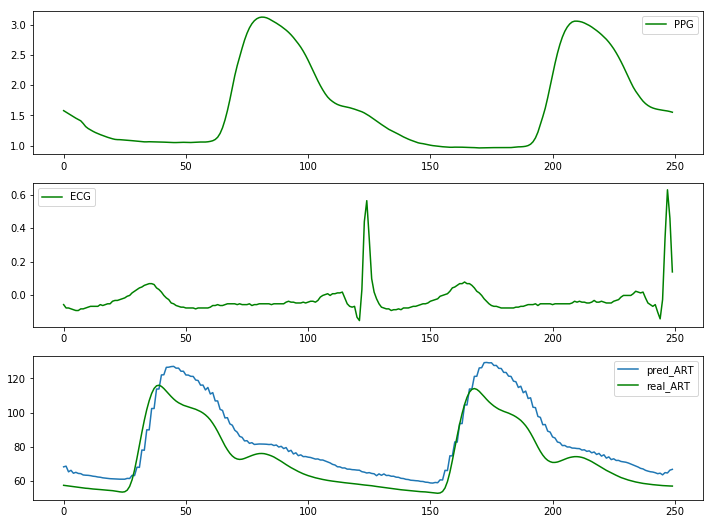

In [437]:
#Example
ix=10
print(np.expand_dims(testX_n[ix,:], axis=0).shape)

plt.figure(figsize=(12,9))
ax = plt.subplot(3,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(3,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
plt.legend()

preds = []
for i in range(5):
    preds.append(autoencoders[i].predict(testX_n[ix].reshape(1,250,2)))

pred = np.mean(preds, axis=0)
print(pred.shape)

#Predicted vs real
ax = plt.subplot(3,1,3)
ax.plot(pred.reshape(250,1), label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()
plt.show()